# Prediction of Credit Scores with Dimensional Reduction and Clustering

### Introduction

Credit ratings agencies collect data and use them to estimate consumers' creditworthiness. Higher credit scores often correspond to lower interest rates on loans offered to an applicant -- the less risk the bank must assume, the less potential profit they will demand in return.

Due to the wide variety of data collected about most consumers, predicting credit scores can be challenging. Consider the categorical variables such as types of loans an applicant may have (auto, home, debt consolidation) or broad categories of spending behavior (low/high spend, low/high value). There are a variety of techniques for encoding categorical variables into numeric values for use in modeling. Among the most popular is one-hot encoding. Using this method, categorical features of the data are expanded into multiple distinct features, each corresponding to a categorical value in the original feature. Observations with a particular categorical value are assigned a value of one in the corresponding column, and values of zero in all others. This technique avoids the problem of ascribing an order to numeric labels which do not have any inherent order. In this dataset, one-hot encoding of the categorical features yields a total of more than 6,000 features. Such a highly-dimensional space presents difficulties for clustering, as the data will tend to be quite far from one another, forming very few natural clusters.

This study explores the application of principal component analysis (PCA) to improve the performance of clustering models applied to data of very high dimensionality. The intent is to predict credit scores based on clustering of observations (consumers) following dimensional reduction.

Data were obtained from the following source:

Muhammed, Ç. (2022, October 14). Credit Score Classification Clean Data. Kaggle. https://www.kaggle.com/datasets/clkmuhammed/creditscoreclassification

This notebook is hosted at the following:

https://github.com/y5c/DTSA_5510_Project.git

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS

In [2]:
cs = pd.read_csv('data/credit_scores.csv')

In [3]:
# Wrapper function for saving figures

def save_figure(name):
    plt.savefig(
        name + '.png',
        bbox_inches = 'tight',
        facecolor = 'white',
        transparent = False
    )

### EDA and Data Cleaning

From the below cell, we can observe that the dataset is reasonably large (100,000 entries) and contains 21 numeric dimensions which span a wide range of scales. One of the first tasks preparing the data for analysis will be to rescale the data to prevent any one dimension from dominating distance calculations.

In [4]:
cs.describe()

,ID,Customer_ID,Month,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,...,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,80631.500000,25982.666640,4.500000,33.316340,5.004617e+08,50505.123449,4197.270835,5.368820,5.533570,14.53208,...,21.08141,13.313120,10.470323,5.798250,1426.220376,32.285173,221.220460,107.699208,55.101315,392.697586
std,43301.486619,14340.543051,2.291299,10.764812,2.908267e+08,38299.422093,3186.432497,2.593314,2.067098,8.74133,...,14.80456,6.237166,6.609481,3.867826,1155.129026,5.116875,99.680716,132.267056,39.006932,201.652719
min,5634.000000,1006.000000,1.000000,14.000000,8.134900e+04,7005.930000,303.645417,0.000000,0.000000,1.00000,...,0.00000,0.000000,0.500000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,43132.750000,13664.500000,2.750000,24.000000,2.451686e+08,19342.972500,1626.594167,3.000000,4.000000,7.00000,...,10.00000,9.000000,5.380000,3.000000,566.072500,28.052567,144.000000,29.268886,27.959111,267.615983
50%,80631.500000,25777.000000,4.500000,33.000000,5.006886e+08,36999.705000,3095.905000,5.000000,5.000000,13.00000,...,18.00000,14.000000,9.400000,5.000000,1166.155000,32.305784,219.000000,66.462304,45.156550,333.865366
75%,118130.250000,38385.000000,6.250000,42.000000,7.560027e+08,71683.470000,5957.715000,7.000000,7.000000,20.00000,...,28.00000,18.000000,14.850000,8.000000,1945.962500,36.496663,302.000000,147.392573,71.295797,463.215683
max,155629.000000,50999.000000,8.000000,56.000000,9.999934e+08,179987.280000,15204.633333,11.000000,11.000000,34.00000,...,62.00000,25.000000,29.980000,17.000000,4998.070000,50.000000,404.000000,1779.103254,434.191089,1183.930696


Some of the features will be relevant, such as Annual_Income and Outstanding_Debt. Others appear superfluous, such as Name and SSN. These unnecessary features must be removed. Also of note is that entries are kept for multiple months. For purposes of clustering, this is a problem. Clusters will form around individuals, who have similar characteristics from one month to another. Instead, we are interested in identifying clusters that form between individuals. It is necessary to select one month and proceed with the analysis from a reduced dataset.

Credit scores are given as categories, and take values 'Poor', 'Standard', and 'Good'.

In [5]:
cs.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.843333,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


Digging a bit further into the data reveals that there are some strong correlations among the dimensions. Certain dimensionality reduction techniques, such as PCA, are quite robust against highly multicollinear data, and this should not present any difficulties.

<AxesSubplot: >

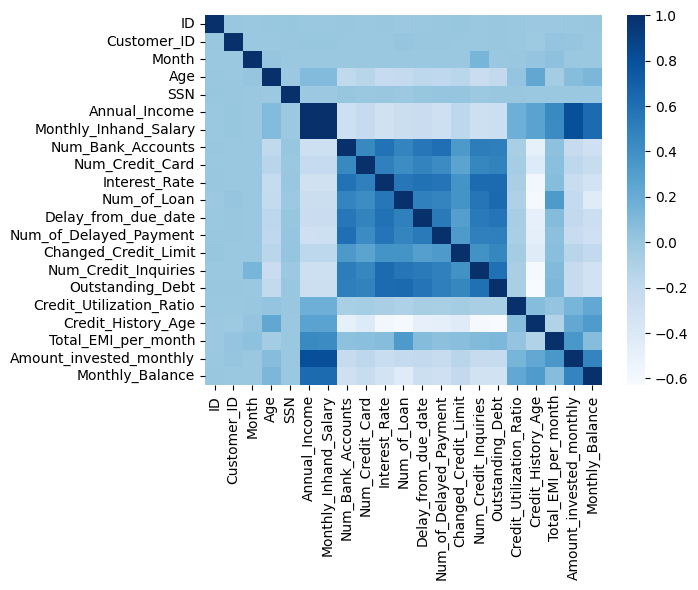

In [6]:
sns.heatmap(
    cs.corr(numeric_only = True),
    cmap = 'Blues'
)

Cleaning the data in preparation for dimensional reduction and modeling. Numeric data are rescaled, and not standardized. The process of standardization centers the data and transforms it to have a variance of one. Because we intend to perform PCA, which selects mutually orthogonal dimensions along which the data have maximal variance, it is best to preserve the variance in the numeric data. Otherwise each numeric variable will appear equally significant to the PCA algorithm, which may result in a significant loss of information.

In [7]:
# Need to choose a particular month, otherwise the model will naturally cluster the same individual
cs = cs[cs['Month'] == 8]

score = cs['Credit_Score']

# Remove dimensions that do not provide useful information
cs.drop(
    ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_Score'],
    axis = 'columns',
    inplace = True
)

# Re-scale the numeric dimensions
numeric = cs.select_dtypes(exclude = ['object'])
numeric = minmax_scale(numeric)

# Encode categorical variables
non_numeric = cs.select_dtypes(include = ['object'])
non_numeric = pd.get_dummies(non_numeric)

cs_scaled = np.hstack((numeric, non_numeric))

Observe that the dataset now consists of more than 6,000 features.

In [8]:
cs_scaled_vis = pd.DataFrame(cs_scaled)
cs_scaled_vis.describe()

,0,1,2,3,4,5,6,7,8,9,...,6295,6296,6297,6298,6299,6300,6301,6302,6303,6304
count,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,...,12500.000000,12500.000000,12500.000000,12500.00000,12500.000000,12500.00000,12500.000000,12500.000000,12500.000000,12500.000000
mean,0.466632,0.251468,0.260734,0.488073,0.503055,0.410063,0.392542,0.339986,0.532416,0.338462,...,0.458480,0.115040,0.359280,0.52568,0.145360,0.20288,0.116640,0.108160,0.139840,0.287120
std,0.256375,0.221416,0.213437,0.235888,0.188217,0.264898,0.271827,0.238742,0.249282,0.224200,...,0.498293,0.319083,0.479809,0.49936,0.352478,0.40216,0.321004,0.310595,0.346835,0.452436
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.261905,0.071320,0.088677,0.272727,0.363636,0.181818,0.222222,0.161290,0.360000,0.166214,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.452381,0.173393,0.186743,0.454545,0.454545,0.363636,0.333333,0.290323,0.560000,0.302239,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.666667,0.373899,0.378748,0.636364,0.636364,0.575758,0.555556,0.451613,0.720000,0.488806,...,1.000000,0.000000,1.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Dimensional Reduction

Performing PCA, we can see that a few components are responsible for the majority of the variance in the data. We can restrict our analysis to the first five components without a significant loss of information.

Text(0, 0.5, 'Explained variance ratio')

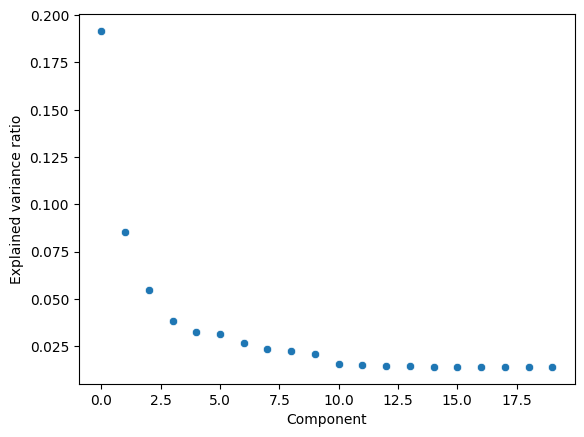

In [9]:
pca = PCA(n_components = 20)
cs_reduced = pca.fit_transform(cs_scaled)

sns.scatterplot(
    x = range(pca.explained_variance_ratio_.shape[0]),
    y = pca.explained_variance_ratio_
)

plt.xlabel('Component')
plt.ylabel('Explained variance ratio')

In [10]:
pca = PCA(n_components = 5)
cs_reduced = pca.fit_transform(cs_scaled)

Our very large dataset has now been reduced to a far more manageable five dimensions. Unfortunately, these dimensions have no intuitive or real-world meaning. They are nonetheless useful for further analysis and greatly reduce the computational complexity of clustering.

In [11]:
cs_reduced_vis = pd.DataFrame(cs_reduced)
cs_reduced_vis.describe()

,0,1,2,3,4
count,1.250000e+04,1.250000e+04,1.250000e+04,1.250000e+04,1.250000e+04
mean,9.976020e-17,6.991741e-17,-7.958079e-18,2.813749e-17,2.721379e-16
std,9.557163e-01,6.381108e-01,5.107703e-01,4.261330e-01,3.935912e-01
min,-1.522560e+00,-1.059608e+00,-8.345320e-01,-6.591645e-01,-3.849218e-01
25%,-8.130229e-01,-6.368156e-01,-3.694254e-01,-3.385203e-01,-1.994349e-01
50%,-3.382228e-01,2.635230e-01,-1.854609e-01,-1.273385e-02,-1.424921e-01
75%,1.085847e+00,4.982122e-01,5.770606e-01,1.473840e-01,-1.021590e-03
max,1.712184e+00,1.185247e+00,1.009647e+00,9.620914e-01,1.402350e+00


### Clustering

We can get a sense of the distribution of the dimensionally reduced data by considering a more extreme example. In this case, we will consider only three dimensions of the transformed data, and produce a scatterplot (the hue of the points represents values in the third dimension). The data clearly form seven clusters in the first two dimensions, and appear to form approximately 14 clusters in the first three dimensions. Although this does not conclusively demonstrate clustering in the full five-dimensional space, it is at least somewhat indicative that the data can be described in terms of several natural clusters of similar size.

<AxesSubplot: >

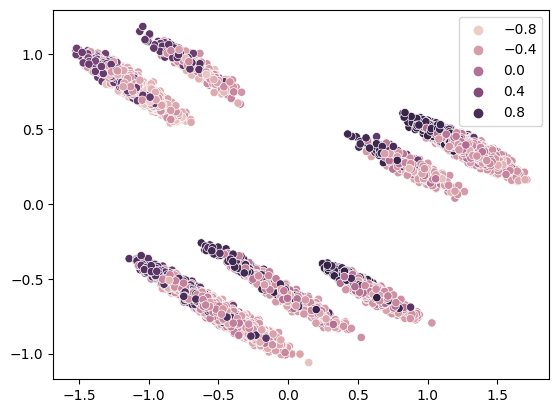

In [12]:
sns.scatterplot(
    x = cs_reduced[:, 0],
    y = cs_reduced[:, 1],
    hue = cs_reduced[:, 2]
)

Two clustering algorithms, k-means and OPTICS, are fit to the data. Clusters are labeled with the most common credit score category among observations in the cluster. Accuracy is defined as the proportion of observations in a cluster that have the same credit score as the cluster label.

In [13]:
def assess_clustering(labels, score):

    n_clusters = 1 + labels.max()

    prop_clustered = labels[labels != -1].shape[0]/labels.shape[0]

    n_correct = 0
    for ind in range(n_clusters):
        cluster = score[labels == ind]
        n_correct += cluster.value_counts()[0]
    accuracy = n_correct/labels[labels != -1].shape[0]

    return n_clusters, prop_clustered, accuracy

From the below plot, it is clear that the number of k-means clusters does not strongly affect the accuracy of credit score clustering. This suggests that the best practice (for the k-means model) is to proceed with a small number of clusters.

Text(0, 0.5, 'Accuracy')

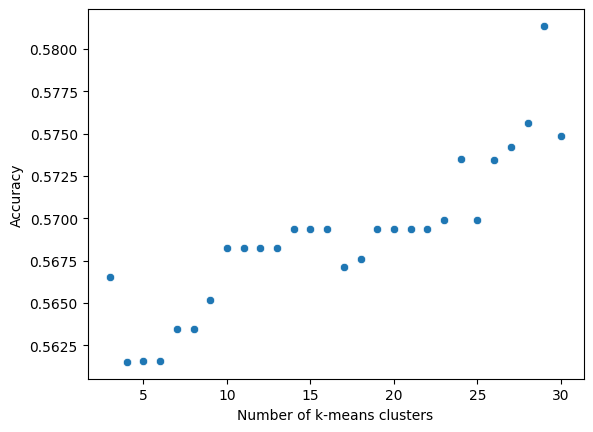

In [14]:
cluster_range = range(3, 31)
prop_clustered = list()
accuracy = list()

for n in cluster_range:
    
    km = KMeans(n_clusters = n)
    km.fit(cs_reduced)

    clusters_n, prop_clustered_n, accuracy_n = assess_clustering(km.labels_, score)

    prop_clustered.append(prop_clustered_n)
    accuracy.append(accuracy_n)

sns.scatterplot(
    x = cluster_range,
    y = accuracy
)

plt.xlabel('Number of k-means clusters')
plt.ylabel('Accuracy')

The OPTICS algorithm is similar to DBSCAN in that it forms clusters based on spatial density. Of particular interest for this project, the scikit-learn implementation of OPTICS is optimized for memory use, which allows it to execute on even on a machine with reduced main memory capacity. OPTICS classifies some points as outliers, and these are excluded from the accuracy calculations. 

A high accuracy and a high proportion of observations clustered are indicative of a well-behaved model. As with many models, a number of hyperparameters are available for tuning, but OPTICS is somewhat unique among clustering algorithms in that most of the hyperparameters tend not to have a strong effect on the clustering. Of interest to us is the minimum cluster size parameter, which sets a floor value for the membership of each cluster. It seems that a minimum cluster size of approximately 35 is optimal in this case.

Text(0, 0.5, 'Proportion of observations clustered')

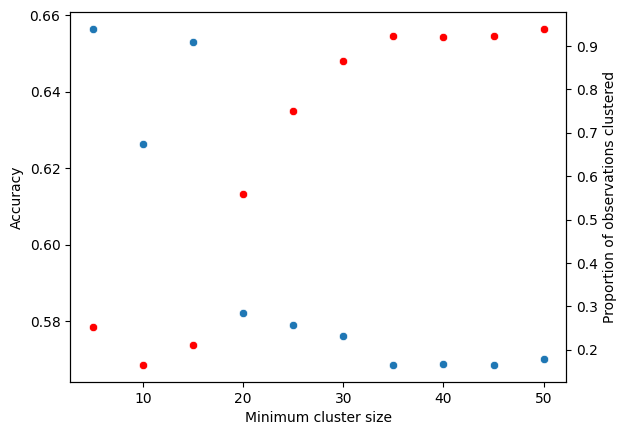

In [15]:
min_cluster_range = range(5, 55, 5)
prop_clustered = list()
accuracy = list()

for n in min_cluster_range:
    
    optics = OPTICS(min_cluster_size = n)
    optics.fit(cs_reduced)

    clusters_n, prop_clustered_n, accuracy_n = assess_clustering(optics.labels_, score)

    prop_clustered.append(prop_clustered_n)
    accuracy.append(accuracy_n)

ax1 = plt.subplot()
ax2 = ax1.twinx()   

sns.scatterplot(
    x = min_cluster_range,
    y = accuracy,
    ax = ax1
)

sns.scatterplot(
    x = min_cluster_range,
    y = prop_clustered,
    color = 'r',
    ax = ax2
)

ax1.set_xlabel('Minimum cluster size')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Proportion of observations clustered')

### Conclusion

In this project, we have utilized a variety of methods for clustering data pertaining to credit scores. Due to the wide range of possible values for certain categorical features, it was necessary to implement a dimensional reduction technique such as principal component analysis. Without such measures, clustering would have proven intractable.

Both k-means clustering and OPTICS were employed to cluster observations. Neither were able to achieve accuracies of greater than 60% with otherwise reasonable performance. However, an accuracy of approximately 60% should not be dismissed. Recall that we use the naive approach of ascribing to each cluster a label corresponding to the most common score category in that cluster. This is a very simplistic predictive technique, and accuracy could no doubt be improved significantly with the application of supervised techniques on a per-cluster basis. In any case, the clustering in this project could serve as an effective first step toward developing a capable, highly-accurate model for predicting credit scores.

### References

2.3. clustering. scikit. https://scikit-learn.org/stable/modules/clustering.html 

Muhammed, Ç. (2022, October 14). Credit Score Classification Clean Data. Kaggle. https://www.kaggle.com/datasets/clkmuhammed/creditscoreclassification